In [14]:
from dotenv import load_dotenv
from groq import Groq
import os
load_dotenv()
import json_repair
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

client = Groq(api_key=os.getenv('GROQ_API_KEY'))

In [15]:
from pydantic import BaseModel, EmailStr, field_validator, Field
from typing import Literal, List

class EmailContent(BaseModel):
    sender: str
    subject: str
    body: str

class Messages(BaseModel):
    role: Literal['user', 'assistant', 'system']
    content: str

class EmailState(BaseModel):
    email: EmailContent

    is_spam: bool = Field(None, description="boolean value to descripe is the email is spam or not")
    spam_reason: str = Field(None, description="for the spam emails, this field will carry the answer of the WHY question.")
    email_category: Literal["thanking", "inquire", "spam", "not-specified"] = None
    messages: List[Messages] = []



In [16]:
email_content = EmailContent(
    sender="Mohamed Hassan",
    subject="scheduling meeting to understand the RMS system",
    body="Hello mr mahrous I need to schedule a meeting with you to make some discussions about the RMS"
)

EmailState(
    email=email_content
)

EmailState(email=EmailContent(sender='Mohamed Hassan', subject='scheduling meeting to understand the RMS system', body='Hello mr mahrous I need to schedule a meeting with you to make some discussions about the RMS'), is_spam=None, spam_reason=None, email_category=None, messages=[])

In [17]:
def read_email(state: EmailState):
    """
        Just reading the email and show it.
    """

    email = state.email

    print('='*50)
    print("\n".join([
        "I have recived a new email:\n",
        f"From: {email.sender}",
        f"Subject: {email.subject}",
        f"Body: {email.body}"
    ]))
    print("="*50)

In [113]:
model_response = client.chat.completions.create(
                        model="llama-3.3-70b-versatile",
                        messages=[Messages(role='user', content='hello')],
                        temperature=1
                        ).choices[0].message.content


In [114]:
model_response

'Hello. How can I assist you today?'

In [115]:
def email_extractor(state: EmailState):
    
    print('Extracting email data')
    print('='*50)
    email = state.email
    
    prompt = f"""
As foodics' HR, you will get emails .. analyze this email and determine if it is spam or legitimate.

Email:
From: {email.sender}
Subject: {email.subject}
Body: {email.body}


First, determine if this email is spam. If it is spam make the email class to be 'Spam' then, explain why in the Analysis.
If it is legitimate, categorize it ['Thanking','Inquire','Not-Specified'].
response in this format only:

{{
    "analysis": ...,
    "class": ...
}}
"""
    
    history = state.messages
    
    prompt_message = Messages(role='user', content=prompt)

    context = history + [prompt_message]
    
    model_response = client.chat.completions.create(
                        model="llama-3.3-70b-versatile",
                        messages=context,
                        temperature=1
                        ).choices[0].message.content
                        
    respone = json_repair.loads(model_response)

    context += [Messages(role="assistant", content=model_response)]

    print(f"Email extractor: {context}")
    
    if respone['class'].lower() == 'spam':
        is_spam = True
        spam_reason = respone['analysis'].lower()

    else:
        is_spam = False
        spam_reason = None
    
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": respone['class'].lower(),
        "messages": context
    }
    

In [117]:
def make_draft(state: EmailState):
    print('='*50)
    print('In make_draft method [for non-spam emails]')
    
    email = state.email

    prompt = "\n".join([
        "As a Foodics HR agent, you recived email",
        "you need to make a draft response to the email I will give you",
        "to send it to the CEO to fast review it and could edit it befor sending",
        f"Email sender: {email.sender}",
        f"Email Subject: {email.subject}",
        f"Email Body: {email.body}",
        f"Email Category: {state.email_category}",
        "make the response in this format:",
        "Subject: Re: ...",
        "From: ...",
        "...."
    ])

    context = state.messages

    context.append(Messages(role="user", content=prompt))

    model_response = client.chat.completions.create(
                        model="llama-3.3-70b-versatile",
                        messages=context,
                        temperature=1
                        ).choices[0].message.content

    context.append(Messages(role="assistant", content=model_response))
    
    print(f"Email drafting: {context}")

    return {
        "messages": context
    }

In [118]:
def reporting_spam(state: EmailState):
    
    print('='*50)
    print('Reporting the spam email')
    
    email = state.email
    print("\n".join([
        "I found this SPAM email",
        f"Sender: {email.sender}",
        f"Subject: {email.subject}",
        f"Body: {email.body}"
    ]))

In [119]:
def router(state: EmailState):
    if state.is_spam:
        return 'spam_route'
    else:
        return 'non_spam_route'

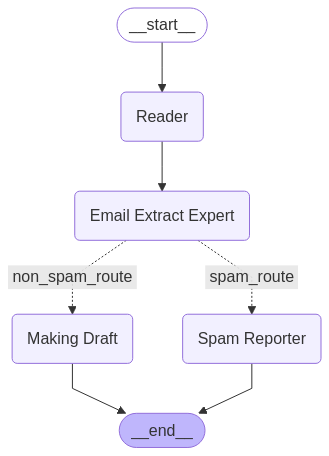

In [120]:
from langgraph.graph import StateGraph, START, END


graph = StateGraph(EmailState)

graph.add_node("Reader", read_email)
graph.add_node("Email Extract Expert", email_extractor)
graph.add_node("Making Draft", make_draft)
graph.add_node("Spam Reporter", reporting_spam)


graph.add_edge(START, "Reader")
graph.add_edge("Reader", "Email Extract Expert")
graph.add_conditional_edges(
    "Email Extract Expert",
    router, 
    {
        "non_spam_route": "Making Draft",
        "spam_route": "Spam Reporter"
    }

)
graph.add_edge("Spam Reporter", END)
graph.add_edge("Making Draft", END)

# graph.add_conditional_edge()
graph = graph.compile()
graph

In [121]:
email_content = EmailContent(
    sender="Koshari Alamin Resturant",
    subject="Asking for price offer",
    body="Hello foodics, I need to ask for your process of joining you as a client."
)


email_state = EmailState(
    email=email_content
)

In [122]:
result = graph.invoke(email_state)

I have recived a new email:

From: Koshari Alamin Resturant
Subject: Asking for price offer
Body: Hello foodics, I need to ask for your process of joining you as a client.
Extracting email data
Email extractor: [Messages(role='user', content='\nAs foodics\' HR, you will get emails .. analyze this email and determine if it is spam or legitimate.\n\nEmail:\nFrom: Koshari Alamin Resturant\nSubject: Asking for price offer\nBody: Hello foodics, I need to ask for your process of joining you as a client.\n\n\nFirst, determine if this email is spam. If it is spam make the email class to be \'Spam\' then, explain why in the Analysis.\nIf it is legitimate, categorize it [\'Thanking\',\'Inquire\',\'Not-Specified\'].\nresponse in this format only:\n\n{\n    "analysis": ...,\n    "class": ...\n}\n'), Messages(role='assistant', content='{\n    "analysis": "The email is likely legitimate because it is addressed to \'foodics\' specifically, and the content of the email is a clear and reasonable inquir

In [130]:
for m in result['messages']:
    print('='*100)
    print(m.role)
    print('-'*50)
    print(m.content)
    

user
--------------------------------------------------

As foodics' HR, you will get emails .. analyze this email and determine if it is spam or legitimate.

Email:
From: Koshari Alamin Resturant
Subject: Asking for price offer
Body: Hello foodics, I need to ask for your process of joining you as a client.


First, determine if this email is spam. If it is spam make the email class to be 'Spam' then, explain why in the Analysis.
If it is legitimate, categorize it ['Thanking','Inquire','Not-Specified'].
response in this format only:

{
    "analysis": ...,
    "class": ...
}

assistant
--------------------------------------------------
{
    "analysis": "The email is likely legitimate because it is addressed to 'foodics' specifically, and the content of the email is a clear and reasonable inquiry about the process of joining as a client. The language used is simple and straightforward, without any suspicious links, attachments, or requests for personal information that are common chara

In [99]:
result['messages'][0][1]

{'role': 'user',
 'content': 'As a Foodics HR agent, you recived email\nyou need to make a draft response to the email I will give you\nto send it to the CEO to fast review it and could edit it befor sending\nEmail sender: Koshari Alamin Resturant\nEmail Subject: Asking for price offer\nEmail Body: Hello foodics, I need to ask for your process of joining you as a client.\nEmail Category: inquire\nmake the response in this format:\nSubject: Re: ...\nFrom: ...\n....'}